# Read in the data

In [2]:
#matplotlib inline
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

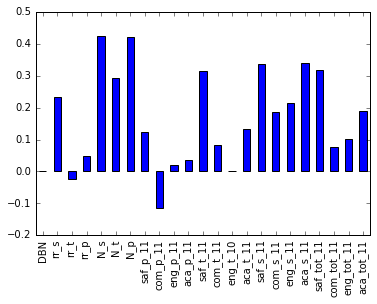

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

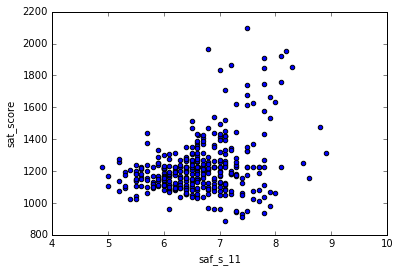

In [12]:
combined.plot.scatter('saf_s_11','sat_score')

# Finding on Correlations between 'sat_score' vs Survey Fields
Among the survey fields, 'N_s' (number of student respondents) and 'N_p' (number of parents respondents) have the highest correlation with 'sat_score' at approximately 0.42. This is followed by 'aca_s_11' (academic expectation score by students), 'saf_s_11' (safety and respect score by students), 'saf_tot_11' (safety and respect total score), and 'saf_t_11' (safety and respect score by teachers), all of which have correlation ranging between 0.3 and 0.35.

The implication from the above observations is that schools that have more students and parents responding to the survey tend to have the students performing better in the SAT exams. However, it is interesting to note that the survey fields that pertain to parents' responses do not actually have strong correlation with students' SAT scores. This suggests that maybe what parents think of the school do not really affect students' performance. Caring enough to take the initiative to respond to the survey would suffice to motivate their children to perform.

On the other hand, having high safety, respect, and academic expectation score on students' accounts would signify higher SAT scores. This is farily self-evident as studying in safe and reputatable environments would better promote the effectiveness of students' studying. Similarly, the same reasoning apply to the teachers.

Lastly, correlations do not explain the causal relationships between SAT scores and survey fields. As noted, the number of students and parents respondents have the highest correlations. However, does the high number of respondents lead to higher SAT scores? Or is it the other way around, schools with higher SAT scores attract higher enrollments, and thus higher number of respondents? In reality, I suspect it is the latter.

# Investigate Which Districts Have the Safest Survey Scores

In [39]:
combined_dist = combined.groupby('school_dist').aggregate(numpy.mean)

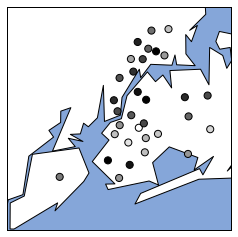

In [40]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc',llcrnrlat=40.496044,urcrnrlat=40.915256,llcrnrlon=-74.255735,urcrnrlon=-73.700272,resolution='i')
x,y = m(combined_dist['lon'].tolist(),combined_dist['lat'].tolist())
m.drawmapboundary(fill_color='#85A6D9')
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawcoastlines()
m.scatter(x,y,s=50,c=combined_dist['saf_s_11'],cmap='binary',zorder=2)

# Safety Score by Distrcts
Using the 'saf_s_11' data to map each distrct's mean safety score, it is observed that schools in Central Brooklyn tend to have higher safety scores. However, schools in the districs of lower Brooklyn, upper Brooklyn, Manhattan Island, and Bronx tend to have lower safety scores.

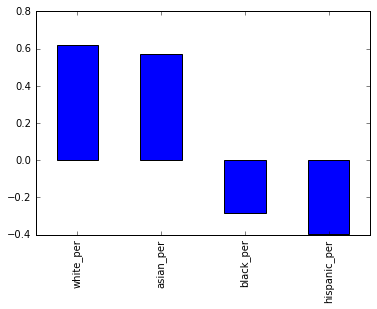

In [15]:
race = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race].plot.bar()

# Correlations between SAT Scores and Racial Enrollment
The SAT scores is positively correlated with the percentages of white and asian enrollments; however, negatively correlated with the black and hispanic students. This outcome is consistent with the general SES among these four ethnic groups.

# Further Investigation on Schools with High/Low Hispanic Enrollment Percentages

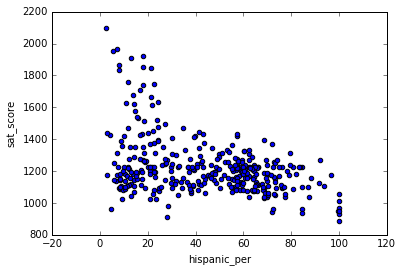

In [17]:
combined.plot.scatter('hispanic_per','sat_score')

In [19]:
combined_high_hisp = combined[combined['hispanic_per'] > 95]
combined_high_hisp['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [27]:
combined_low_hisp = combined[combined['hispanic_per'] < 10]
combined_low_hisp_high_score =combined_low_hisp[combined_low_hisp['sat_score'] > 1800]
combined_low_hisp_high_score['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Investigate Correlations by Gender

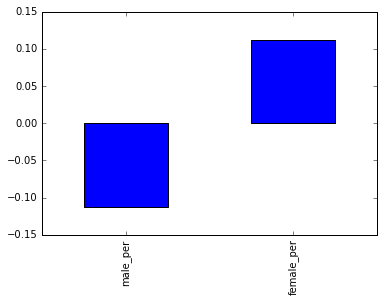

In [29]:
gender = ['male_per','female_per']
combined.corr()['sat_score'][gender].plot.bar()

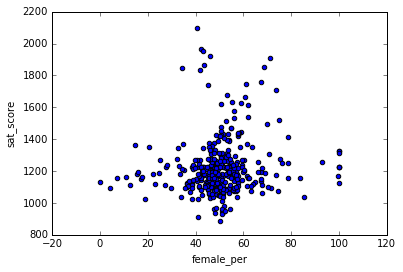

In [31]:
combined.plot.scatter('female_per','sat_score')

Even though schools with higher percentages of female students are positively correlated to SAT scores (corr = 0.1), once the data is shown on a scatter plot, the correlation is not very obvious, and in fact, quite diversed.

In [33]:
combined_high_female = combined[combined['female_per'] > 60]
combined_high_female_high_score = combined_high_female[combined_high_female['sat_score'] > 1700]
combined_high_female_high_score['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Investigate the Correlation between SAT Scores and AP

In [34]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

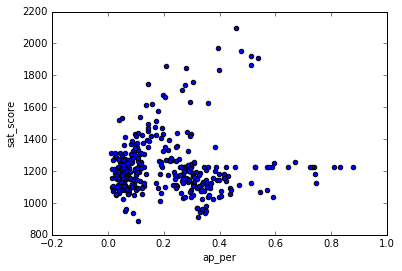

In [35]:
combined.plot.scatter('ap_per','sat_score')

In [36]:
combined.corr()['sat_score']['ap_per']

0.057170813907669669

The scatter chart shows a somewhat weak correlation between SAT scores and the percentage of students taking AP exams. This is confirmed with a correlation of 0.057.

# Investigate Which Distric Has Schools with Highest Average Scores

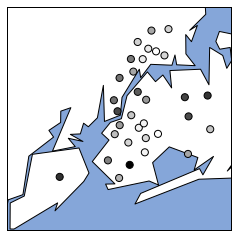

In [42]:
m_sat = Basemap(projection='merc',llcrnrlat=40.496044,urcrnrlat=40.915256,llcrnrlon=-74.255735,urcrnrlon=-73.700272,resolution='i')
x,y = m_sat(combined_dist['lon'].tolist(),combined_dist['lat'].tolist())
m_sat.drawmapboundary(fill_color='#85A6D9')
m_sat.fillcontinents(color='white',lake_color='#85A6D9')
m_sat.drawcoastlines()
m_sat.scatter(x,y,s=50,c=combined_dist['sat_score'],cmap='binary',zorder=2)

# Investigate Correlation between SAT Scores and Class Sizes

In [55]:
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

0.38101433080955233

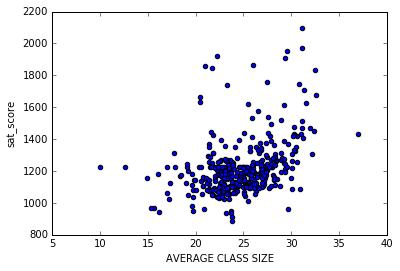

In [54]:
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')

While it is understandable that the number of total enrollment can be influenced by the school having higher SAT performance, it is a surprise to find that the average class size is also positively correlated with SAT scores.

The conventional wisdom dictates that smaller class size should translate to higher academic performance, as each student gets more attention from the instructors. And even though in the first phenomenom where schools with higher SAT scores also have higher total enrollment, it may be explained that those schools may have accomodated the higher enrollments by opening more classes.

However, the above scatter chart shows that is not the case.